# Team Frequency Analysis

Note: some articles missing text - find and re-scrape.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter
from textblob import TextBlob, Word
import nltk
from nltk.corpus import stopwords
import string
import spacy
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
articles_list = pd.read_csv('nyt_scrape/articles_list_w_date.csv',parse_dates=['date'])

In [4]:
articles_list.head(2)

,published_date,article_urls,article_summary,article_headline,title,date
0,2018-06-09T17:31:27+0000,https://www.nytimes.com/2018/06/09/sports/nba-...,"Accused of making the sport uncompetitive, the...",The Warriors Were Dominant. But How Dominant?,nba-finals-sweep,2018-06-09
1,2018-06-09T01:26:37+0000,https://www.nytimes.com/2018/06/08/movies/kyri...,"In his most extensive comments to date, the Bo...",Kyrie Irving Doesn’t Know if the Earth Is Roun...,kyrie-irving-nba-celtics-earth,2018-06-09


## Total Mentions across Corpus:

In [5]:
dir_list = os.listdir('nyt_scrape/new_articles')

In [6]:
corpus = ''

for article in dir_list:
    with open(f'nyt_scrape/new_articles/{article}') as f:
        corpus += f.read()
        corpus += '\n'

corpus = corpus.replace('’','').replace('”','').replace('“','').replace('—','')

In [7]:
corpus_blob = TextBlob(corpus)

In [8]:
tags = corpus_blob.pos_tags
tags = [tag for tag in tags if tag[1] in {'NN','NNS','NNP','NNPS'}]
tags = [Word(tag[0].lower()) for tag in tags]
lemma_tags = [tag.lemmatize() for tag in tags]
lemma_tags = [tag for tag in tags if tag not in ['s','t']]
c2 = Counter(lemma_tags)

In [9]:
team_names = pd.read_csv('team_names.csv')

In [10]:
playoff_dict = {0:'DNQ',1:'First Round',2:'Second Round',3:'Conference Finals',4:'NBA Finals',5:'Champion'}
inverse_playoff_dict = dict(zip(playoff_dict.values(),playoff_dict.keys()))

In [11]:
names = list(team_names['Name'])
team_names['noun_occurrences'] = [c2[name.lower()] for name in names]

In [12]:
team_names.sort_values(['noun_occurrences'],ascending=False).head()

,Name,Wins,Playoffs,Conference,New York Team,City,noun_occurrences
6,Knicks,29,0,E,1,New York,590
2,Warriors,58,5,W,0,Golden State,521
1,Cavaliers,50,4,E,0,Cleveland,370
3,Celtics,55,3,E,0,Boston,302
8,Rockets,65,3,W,0,Houston,296


In [13]:
team_names['playoff_round'] = team_names.Playoffs.apply(lambda x : playoff_dict[x])

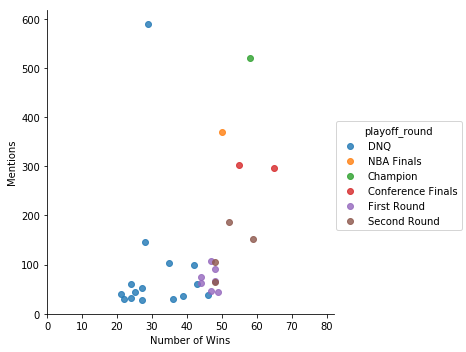

In [14]:
g = sns.lmplot(x="Wins", y="noun_occurrences", hue = "playoff_round",data=team_names,fit_reg = False, legend = True)
g.set_axis_labels(x_var = "Number of Wins", y_var = "Mentions")
g.axes[0,0].set_xlim(0,82)
plt.show()

This graph shows that teams who reach further in the playoffs and who have more wins tend to have significantly more mentions. Notable exceptions to this are the New York Knicks and the Brooklyn Nets - the two local teams that we would expect to be reported more.

# Regular Season Play:

Let's try restricting our analysis to articles written before the start of the postseason to see if teams reaching further in the playoffs are also written more about in the regular season.

In [15]:
postseason_start = pd.to_datetime('2018-04-14')

In [16]:
articles_list['regular_season'] = articles_list.date < postseason_start

In [17]:
regular_season_corpus = ''

for index, row in articles_list.iterrows():
    if row['regular_season']:
        article = row["article_urls"].replace("/","").replace(".","")
        with open(f'nyt_scrape/new_articles/{article}.txt') as f:
            regular_season_corpus += f.read()
            regular_season_corpus += '\n'

In [18]:
regular_blob = TextBlob(regular_season_corpus)
tags = regular_blob.pos_tags
tags = [tag for tag in tags if tag[1] in {'NN','NNS','NNP','NNPS'}]
tags = [Word(tag[0].lower()) for tag in tags]
lemma_tags = [tag.lemmatize() for tag in tags]
lemma_tags = [tag for tag in tags if tag not in ['s','t']]
c3 = Counter(lemma_tags)

In [19]:
team_names['regular_occurrences'] = [c3[name.lower()] for name in names]

In [20]:
team_names.sort_values(['regular_occurrences'],ascending=False).head()

,Name,Wins,Playoffs,Conference,New York Team,City,noun_occurrences,playoff_round,regular_occurrences
6,Knicks,29,0,E,1,New York,590,DNQ,559
2,Warriors,58,5,W,0,Golden State,521,Champion,168
1,Cavaliers,50,4,E,0,Cleveland,370,NBA Finals,147
24,Nets,28,0,E,1,Brooklyn,146,DNQ,145
3,Celtics,55,3,E,0,Boston,302,Conference Finals,130


In [21]:
team_names.sort_values(['regular_occurrences'],ascending=True).head()

,Name,Wins,Playoffs,Conference,New York Team,City,noun_occurrences,playoff_round,regular_occurrences
7,Bulls,27,0,E,0,Chicago,28,DNQ,18
15,Timberwolves,47,1,W,0,Minnesota,46,First Round,23
20,Blazers,49,1,W,0,Portland,44,First Round,24
25,Grizzlies,22,0,E,0,Memphis,29,DNQ,25
16,Hornets,36,0,E,0,Charlotte,31,DNQ,29


Immediately we find the Knicks and Nets are even more heavily favoured.

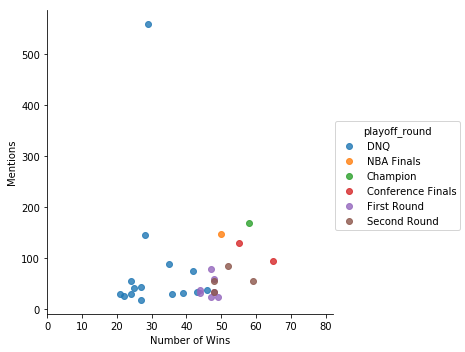

In [22]:
g = sns.lmplot(x="Wins", y="regular_occurrences", hue = "playoff_round",data=team_names,fit_reg = False, legend = True)
g.set_axis_labels(x_var = "Number of Wins", y_var = "Mentions")
g.axes[0,0].set_xlim(0,82)
plt.show()

Using this we see much more of a parity across all teams (except for the Knicks), with the fewest mentions being the Chicago Bulls at 18.

Let's try to fit a linear regression model to this data to examine the underlying effects of each factor:

In [23]:
from sklearn.linear_model import LinearRegression

In [24]:
model = LinearRegression()

In [25]:
team_names.head()

,Name,Wins,Playoffs,Conference,New York Team,City,noun_occurrences,playoff_round,regular_occurrences
0,Lakers,35,0,W,0,Los Angeles,103,DNQ,88
1,Cavaliers,50,4,E,0,Cleveland,370,NBA Finals,147
2,Warriors,58,5,W,0,Golden State,521,Champion,168
3,Celtics,55,3,E,0,Boston,302,Conference Finals,130
4,Spurs,47,1,W,0,San Antonio,108,First Round,79


In [26]:
team_names.Conference = team_names.Conference.apply(lambda x : 0 if x=="E" else 1)

In [27]:
predictor_cols = ['Wins','Playoffs','Conference','New York Team']
model.fit(team_names[predictor_cols],team_names.regular_occurrences)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [28]:
coefs = zip(predictor_cols,model.coef_)

In [29]:
for coef in coefs:
    print(f"Our model predicts that for a unit increase in {coef[0]}, a team will receive **{round(coef[1],2)}** more mentions in the NYT during the regular season.\n")

Our model predicts that for a unit increase in Wins, a team will receive **-0.52** more mentions in the NYT during the regular season.

Our model predicts that for a unit increase in Playoffs, a team will receive **26.2** more mentions in the NYT during the regular season.

Our model predicts that for a unit increase in Conference, a team will receive **7.36** more mentions in the NYT during the regular season.

Our model predicts that for a unit increase in New York Team, a team will receive **320.02** more mentions in the NYT during the regular season.



Perhaps interesting to note is that being in the Western Conference appears to be a strong predictor of mentions and that actually winning more games would result in less mentions - this seems likely because the data is distorted by the high level of mentions for the Knicks.

## Try dropping New York teams:

In [30]:
team_names.drop([6,24],inplace = True)  # Remove Knicks, Nets

In [31]:
model = LinearRegression()
model.fit(team_names[predictor_cols],team_names.regular_occurrences)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [32]:
coefs = zip(predictor_cols,model.coef_)

In [33]:
for coef in coefs:
    print(f"Our model predicts that for a unit increase in {coef[0]}, a team will receive **{round(coef[1],2)}** more mentions in the NYT during the regular season.\n")

Our model predicts that for a unit increase in Wins, a team will receive **-0.64** more mentions in the NYT during the regular season.

Our model predicts that for a unit increase in Playoffs, a team will receive **27.0** more mentions in the NYT during the regular season.

Our model predicts that for a unit increase in Conference, a team will receive **7.56** more mentions in the NYT during the regular season.

Our model predicts that for a unit increase in New York Team, a team will receive **0.0** more mentions in the NYT during the regular season.



Even when discounting the New York teams winning games still appears to negatively impact the number of mentions. Clearly all the benefit of being a good team is correlated with performing well in the playoffs - each round a team will progress in future is worth 27 more mentions throughout the regular season.

## Remove Playoffs as a predictor:

In [34]:
predictor_cols = ['Wins','Conference']
model = LinearRegression()
model.fit(team_names[predictor_cols],team_names.regular_occurrences)
coefs = zip(predictor_cols,model.coef_)
for coef in coefs:
    print(f"Our model predicts that for a unit increase in {coef[0]}, a team will receive **{round(coef[1],2)}** more mentions in the NYT during the regular season.\n")

Our model predicts that for a unit increase in Wins, a team will receive **1.62** more mentions in the NYT during the regular season.

Our model predicts that for a unit increase in Conference, a team will receive **5.42** more mentions in the NYT during the regular season.



Finally in this case we see a benefit to receiving more wins.

Plotting this with seaborn:

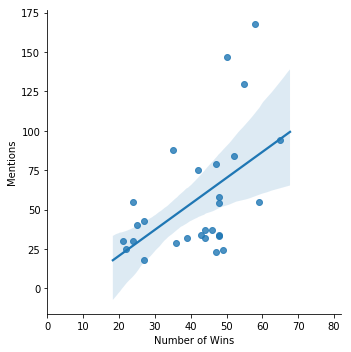

In [35]:
g = sns.lmplot(x="Wins", y="regular_occurrences", data=team_names,fit_reg = True, legend = True)
g.set_axis_labels(x_var = "Number of Wins", y_var = "Mentions")
g.axes[0,0].set_xlim(0,82)
plt.show()

# Sentiment Analysis:

What may be more interesting and insightful is if we can track the performance of teams based on the sentiment of articles written about them.

First create a dictionary that maps article title to article date:

In [36]:
file_title = articles_list.article_urls.apply(lambda x : x.replace("/","").replace(".",""))
article_date = articles_list.date

title_date_dict = dict(zip(file_title,article_date))

Store each article as a list of paragraphs in dictionary mapping title to article:

In [42]:
title_text_dict = dict()

for article in file_title:
    with open(f'nyt_scrape/new_articles/{article}.txt') as f:
        title_text_dict[article] = f.read().replace('’','').replace('”','').replace('“','').replace('—','').split('\n')

## Comparing Sentiment classifiers:

**TextBlob:**

In [81]:
para = TextBlob(title_text_dict[file_title[0]][0])

In [82]:
print(para, para.sentiment)

The Golden State Warriors have ruined basketball. Sentiment(polarity=0.3, subjectivity=0.5)


At first glance this sentiment analysis looks to be quite poor - we would hope this paragraph would register negative sentiment.

**Vader Sentiment:**

In [83]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [84]:
vader = SentimentIntensityAnalyzer()

In [85]:
vader.polarity_scores(para)

{'neg': 0.341, 'neu': 0.659, 'pos': 0.0, 'compound': -0.4767}

Let's compare the two methods over the course of a wider article:

In [73]:
for para in title_text_dict[file_title[25]][:5]:
    print(f'{para}\nTextBlob Sentiment Scores:{TextBlob(para).sentiment}\nVader Sentiment Scores:{vader.polarity_scores(para)}\n\n')

BOSTON  With a little help from his friends, though not that much, LeBron James dazzled once again in a playoff elimination game, sending the Cavaliers back to the N.B.A. finals on Sunday night and keeping himself in a Cleveland uniform for at least another two weeks.
TextBlob Sentiment Scores:Sentiment(polarity=-0.1375, subjectivity=0.3)
Vader Sentiment Scores:{'neg': 0.0, 'neu': 0.882, 'pos': 0.118, 'compound': 0.6712}


In a game that looked bleak at the outset, with the Cavaliers playing without the injured Kevin Love, James powered an offense that started the game atrociously and then did just enough to break the upstart hearts of the young Boston Celtics, 87-79, in Game 7 of the Eastern Conference finals.
TextBlob Sentiment Scores:Sentiment(polarity=-0.2875, subjectivity=0.5875)
Vader Sentiment Scores:{'neg': 0.036, 'neu': 0.814, 'pos': 0.149, 'compound': 0.7398}


James played all 48 minutes and finished with 35 points, 15 rebounds and 9 assists, missing a triple-double only bec

On balance, Vader Sentiment appears to be more accurately capturing the sentiment of the article.

## Golden State Warriors Sentiment Analysis:

For every paragraph in every article, if "Golden State" or "Warriors" is found in the text of the article, we'll record the sentiment - storing average sentiment in article and number of mentions.

In [86]:
vader = SentimentIntensityAnalyzer()

In [88]:
from collections import defaultdict

In [129]:
title_sentiment_warriors = defaultdict(list)
article_tuples = []

for article in file_title:
    for para in title_text_dict[article]:
        if ("Warriors" in para or "Golden State" in para):
            title_sentiment_warriors[article].append(vader.polarity_scores(para)['compound'])
    if len(title_sentiment_warriors[article]) > 0:
        article_tuples.append((article, np.sum(title_sentiment_warriors[article]),
                                          len(title_sentiment_warriors[article]),
                                            title_date_dict[article]))
    else:
        article_tuples.append((article,0,0,title_date_dict[article]))

Example classification for an article:

In [132]:
print(article_tuples[3])
print('\n'.join(title_text_dict[file_title[3]])[:1000],'...')

('https:wwwnytimescom20180608sportslebron-james-free-agencyhtml', 2.2406, 7, Timestamp('2018-06-08 00:00:00'))
CLEVELAND  The biggest revelation we got from LeBron James after what might have been the final game he ever plays for the Cleveland Cavaliers had nothing to do with his pending free agency. It was health-related.
It turns out that the nasty poke in the left eye that James incurred from Draymond Green in Game 1 of the N.B.A. finals was not the most severe injury he suffered that night.
From the postgame podium late Friday, after his Cavaliers were mercilessly broomed out of the finals by the Golden State Warriors, James had an admission to share: He hurt his right hand badly after that crushing Game 1 defeat in a self-inflicted fit of pique.
Responding to reports that he punched a whiteboard in frustration with Clevelands blown opportunity to steal the series opener on the Warriors floor, James said: I let emotions get the best of me. Pretty much played the last three games wi

In [135]:
sentiment_track = pd.DataFrame(article_tuples,columns = ['Title','Total Sentiment','Mentions','Date']).sort_values('Date')

Add rolling sums:

In [144]:
sentiment_track['Cumulative Sentiment'] = sentiment_track['Total Sentiment'].cumsum()
sentiment_track['Cumulative Mentions'] = sentiment_track['Mentions'].cumsum()

In [145]:
sentiment_track.head()

,Title,Total Sentiment,Mentions,Date,Cumulative Sentiment,Cumulative Mentions
319,https:wwwnytimescom20171012sportsjoel-embiid-7...,0.0000,0,2017-10-12,0.0000,0
318,https:wwwnytimescom20171016sportsbasketballnba...,2.1973,11,2017-10-16,2.1973,11
317,https:wwwnytimescom20171016sportsbasketballwnb...,0.0000,0,2017-10-16,2.1973,11
312,https:wwwnytimescom20171017sportsbasketballleb...,0.9274,1,2017-10-17,3.1247,12
313,https:wwwnytimescom20171017sportsbasketballwnb...,0.0000,0,2017-10-17,3.1247,12


Call a ready-made python script that scrapes the data and saves to csv files:

In [275]:
! python player_stats/team_results_scrape.py GSW

Complete! Output stored in GSW_results.csv and GSW_results_postseason.csv. Ready to load into memory :-)


Note we provide the team acronym as a commandline input, if we use a dodgy acronym, we get this error message:

In [274]:
! python player_stats/team_results_scrape.py THISISNTATEAM

Either your internet connection is broken or you've used the wrong team acronym. Try again!


Read the results files into memory:

In [271]:
gsw_results_postseason = pd.read_csv('player_stats/GSW_results.csv', parse_dates=['Date'])
gsw_results_postseason = pd.read_csv('player_stats/GSW_results_postseason.csv', parse_dates=['Date'])

In [272]:
gsw_results.head()

,Date,Opponent,Tm,Opp,W,L,net_wins,win_flag,text
0,2017-10-17,Houston Rockets,121.0,122.0,0.0,1.0,-1.0,L,L vs Houston Rockets (121-122)
1,2017-10-20,New Orleans Pelicans,128.0,120.0,1.0,1.0,0.0,W,W vs New Orleans Pelicans (128-120)
2,2017-10-21,Memphis Grizzlies,101.0,111.0,1.0,2.0,-1.0,L,L vs Memphis Grizzlies (101-111)
3,2017-10-23,Dallas Mavericks,133.0,103.0,2.0,2.0,0.0,W,W vs Dallas Mavericks (133-103)
4,2017-10-25,Toronto Raptors,117.0,112.0,3.0,2.0,1.0,W,W vs Toronto Raptors (117-112)


In [273]:
gsw_results_postseason.head()

,Date,Opponent,Tm,Opp,W,L,net_wins,win_flag,text
0,2018-04-14,San Antonio Spurs,113,92,1,0,1,W,W vs San Antonio Spurs (113-92)
1,2018-04-16,San Antonio Spurs,116,101,2,0,2,W,W vs San Antonio Spurs (116-101)
2,2018-04-19,San Antonio Spurs,110,97,3,0,3,W,W vs San Antonio Spurs (110-97)
3,2018-04-22,San Antonio Spurs,90,103,3,1,2,L,L vs San Antonio Spurs (90-103)
4,2018-04-24,San Antonio Spurs,99,91,4,1,3,W,W vs San Antonio Spurs (99-91)


Plot with plotly:

In [225]:
import  plotly.plotly  as py
import plotly.graph_objs as go

In [265]:
trace0 = go.Scatter(
    x = gsw_results.Date,
    y = gsw_results.net_wins,
    mode = 'lines+markers',
    name = 'Net Wins (Regular Season)',
    text=gsw_results.text,
    hoverinfo='text'
)

In [266]:
trace1 = go.Scatter(
    x = sentiment_track.Date,
    y = sentiment_track['Cumulative Sentiment'],
    mode = 'lines',
    name = 'Cumulative Sentiment'
)

In [267]:
trace2 = go.Scatter(
    x = gsw_results_postseason.Date,
    y = gsw_results_postseason.net_wins,
    mode = 'lines+markers',
    name = 'Net Wins (Postseason)',
    text=gsw_results_postseason.text,
    hoverinfo='text'
)

In [268]:
trace3 = go.Bar(
    x = sentiment_track.Date,
    y = sentiment_track['Mentions'],
    name = 'Daily Mentions'
)

In [269]:
layout = dict(title = 'Comparison of cumulative sentiment against GSW Record',
              xaxis = dict(title = 'Date')
              )

In [270]:
fig = dict(data=[trace0,trace2,trace1,trace3], layout=layout)
py.iplot(fig, filename='sentiment_vs_wins')